In [1]:
import pandas as pd
import numpy as np
import re

from IPython.display import Markdown

from joblib import parallel_backend, dump, load

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer, log_loss

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
            GridSearchCV

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from wordcloud import WordCloud

from code.cleaner import preprocess
from code.viz import word_plot
from code.scoring import custom_scorer

sns.set()

In [2]:
sentiments = pd.read_csv(
    './data/judge-1377884607_tweet_product_company.csv',
    encoding='ISO-8859-1')
sentiments.tail()

tweet_text  \
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
9088                            iPad   
9089                             NaN   
9090                             NaN   
9091                             NaN   
9092                             NaN   

     is_there_an_emotion_directed_at_a_brand_or_product  
9088                                   Positive emotion  
9089                 No emotion toward brand or product  
9090                 No emotion toward brand or product  
9091                 No emotion toward brand or product  
9092                 No emotion toward brand or product

In [3]:
# sentiments['product'] = sentiments['emotion_in_tweet_is_directed_at']
# sentiments['sentiment'] = sentiments['is_there_an_emotion_directed_at_a_brand_or_product']

sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [4]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [5]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

Here, we'll split off the sentiments listed as "I can't
tell" into their own dataframe and drop them from the
original.

In [6]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

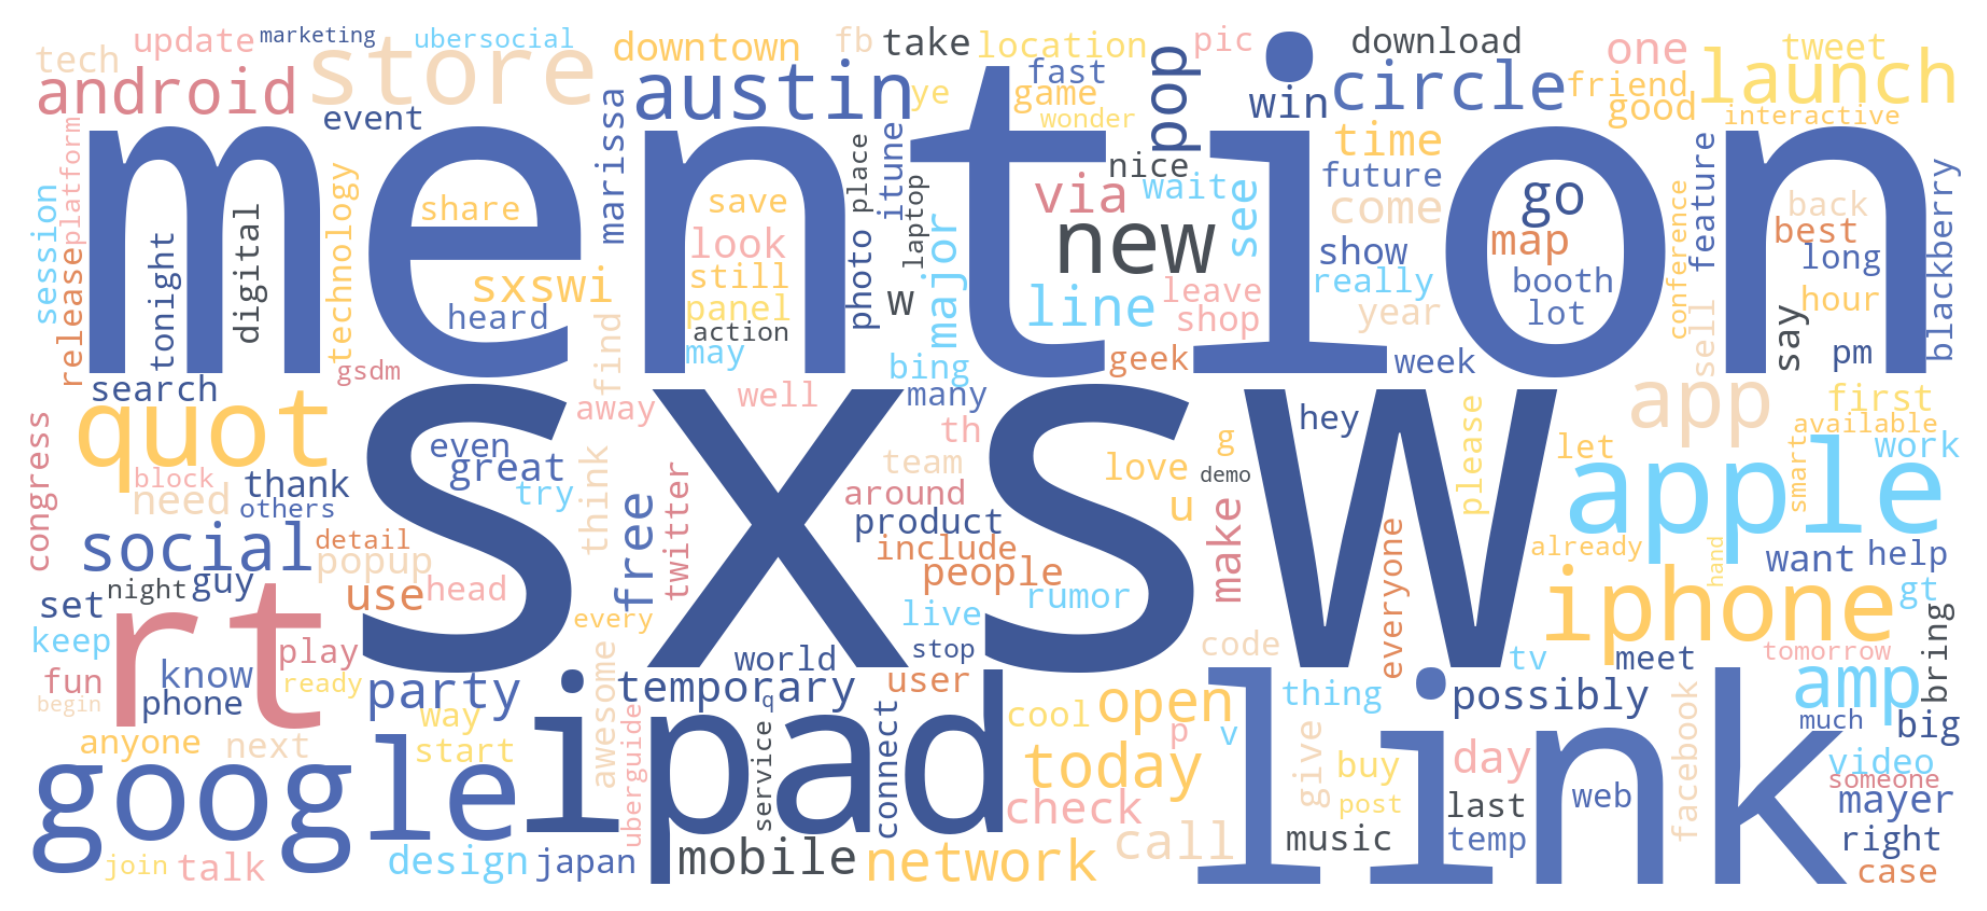

In [14]:
cloud = sentiments.copy()

cloud['tokenized'], cloud['tokens'] = \
    preprocess(cloud['tweet_text'], ret_tokens=True)

cloud['tokens_str'] = [' '.join(token_list) for token_list in cloud['tokens']]

canvamap = ListedColormap(['#3f5896', '#494f56', '#4f6ab3', '#5773b8', '#76d3fb',
                          '#db868e', '#e28a5c', '#f4d9bc', '#f7b2b0', '#fddf75', '#ffcc66'])

wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='#ffffff'
).generate(" ".join(cloud['tokens_str']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
sw = stopwords.words('english')
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

In [8]:
preprocess(sentiments.head()['tweet_text'],sw)

['@wesley g hr tweet #rise dead need upgrade plugin station',
 '@jessedee know @fludapp awesome likely appreciate design also give free t',
 '@swonderlin wait #ipad also sale',
 'hope year festival crashy year',
 '@sxtxstate great stuff fri marissa mayer tim reilly tech book conference amp matt mullenweg wordpress']

In [9]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

In [16]:
# canvamap = [
#     '#3f5896', '#494f56', '#4f6ab3',
#     '#5773b8', '#76d3fb', '#db868e',
#     '#e28a5c', '#f4d9bc', '#f7b2b0',
#     '#fddf75', '#ffcc66'
# ]

Index(['get', 'launch'], dtype='object')


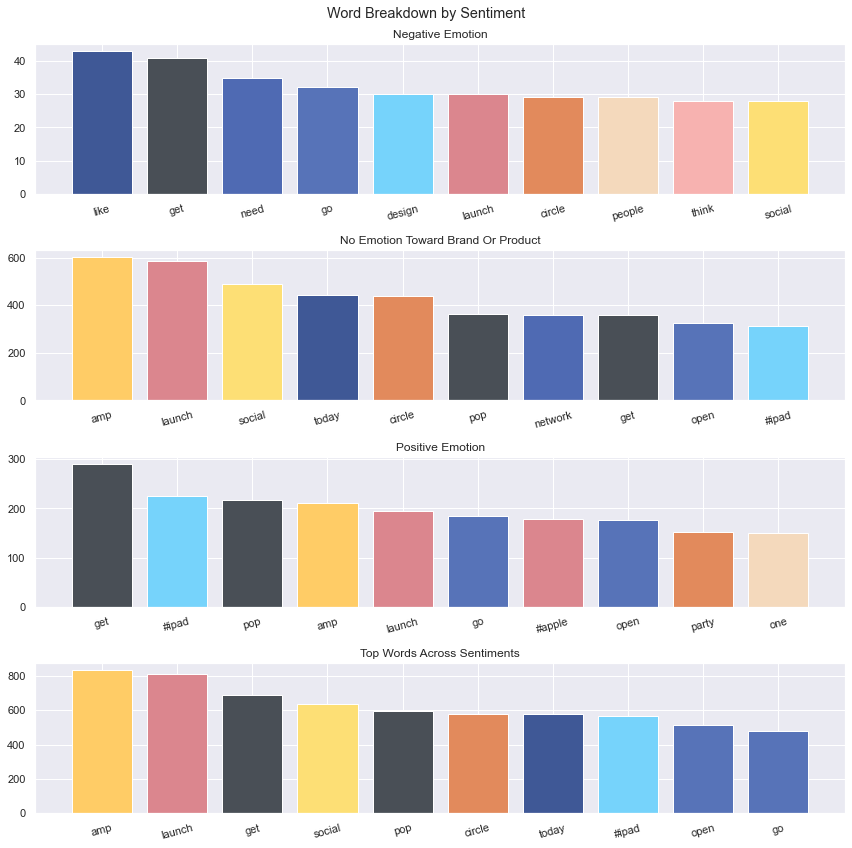

In [11]:
freq_words = word_plot(sentiments, 'sentiment', 'tokens',
    n_words=10, theme=canvamap)
print(freq_words[1])

In [15]:
X = sentiments[['tokenized','tokens']]
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.2,
        stratify=y,random_state=13)

train = X_train.merge(
    y_train,left_index=True,right_index=True
    )
test = X_test.merge(
    y_test,left_index=True,right_index=True
    )

Index(['#ipad', 'get', 'launch', 'line'], dtype='object')


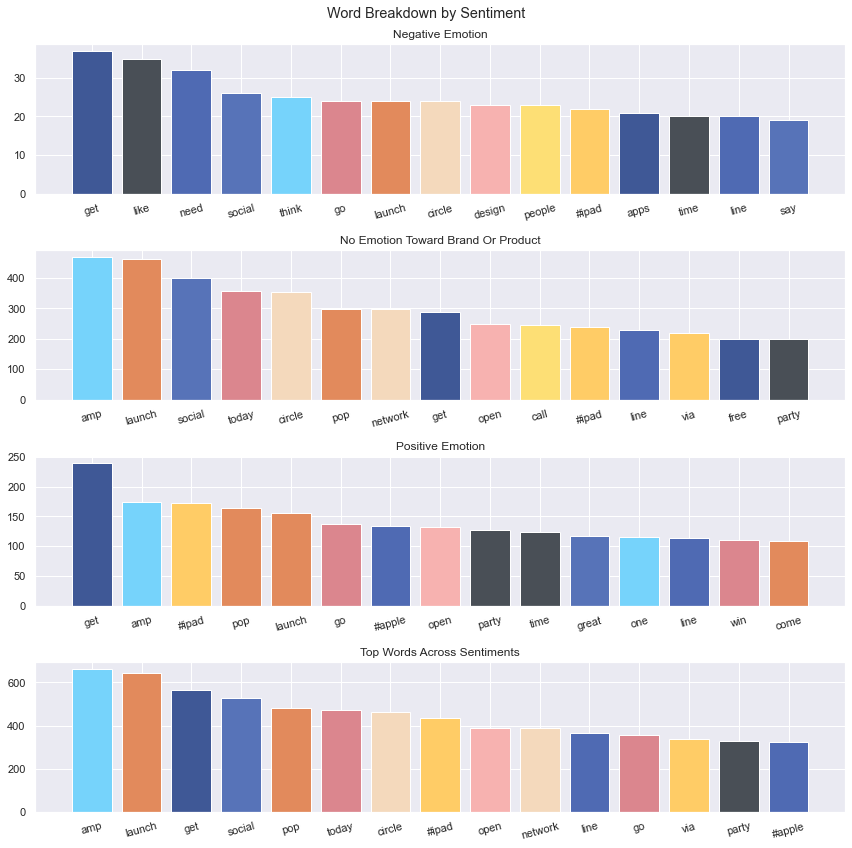

In [17]:
# train = X_train.merge(
#     y_train,left_index=True,right_index=True
#     )
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=canvamap)
print(freq_words[1])

Index(['amp', 'go', 'social'], dtype='object')


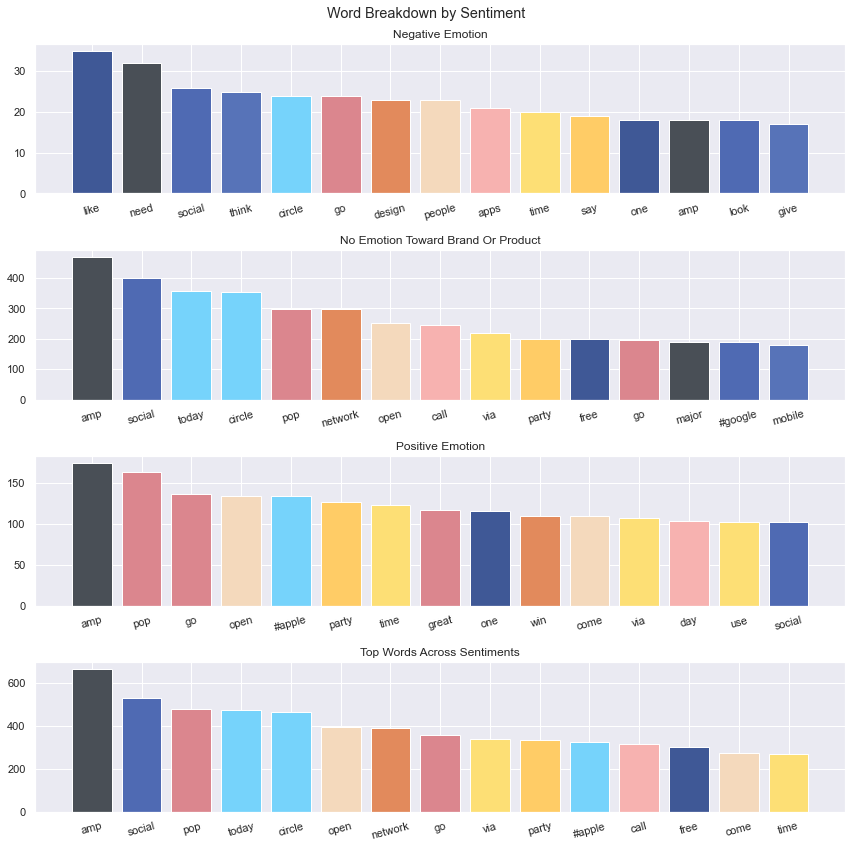

In [15]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=canvamap)
print(freq_words[1])

Index(['today'], dtype='object')


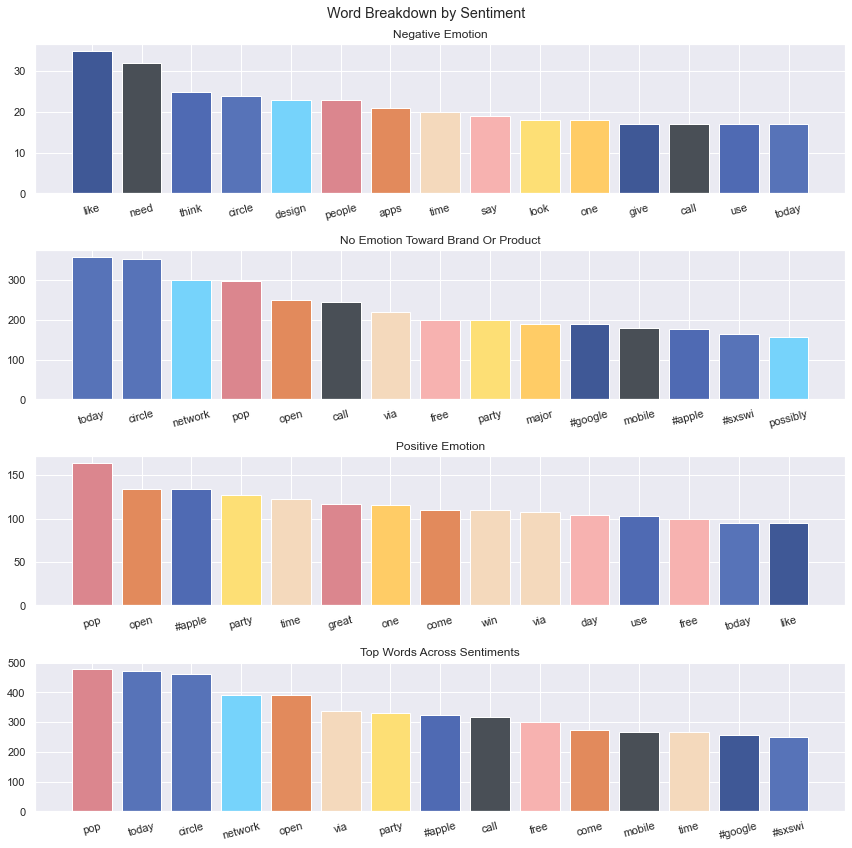

In [16]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=canvamap)
print(freq_words[1])

Index(['pop'], dtype='object')


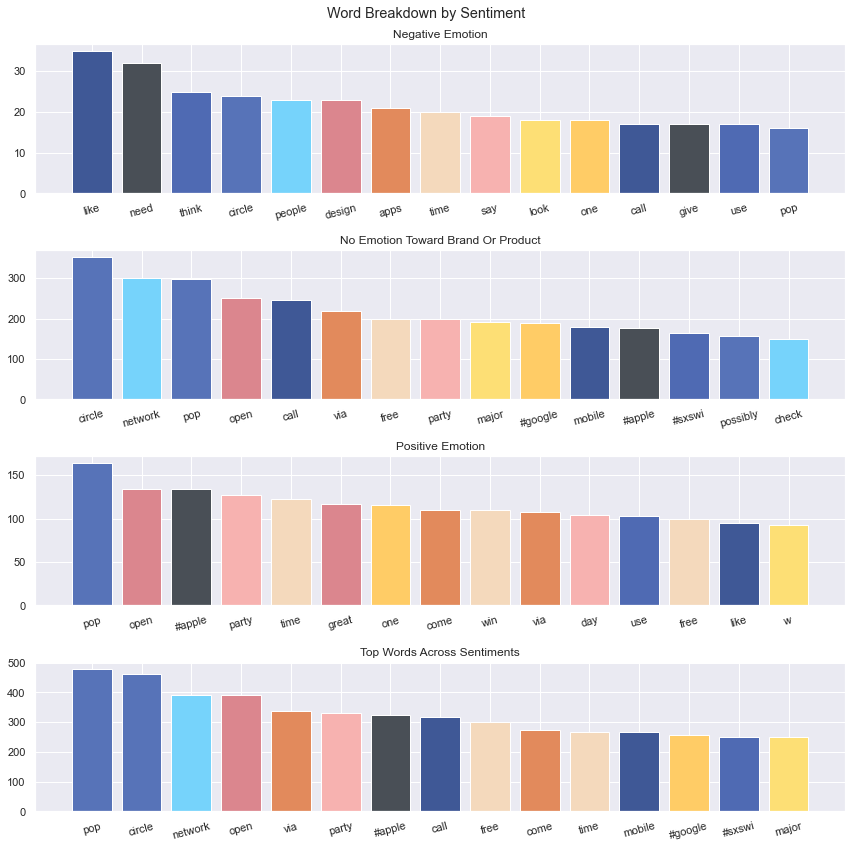

In [17]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=canvamap)
print(freq_words[1])

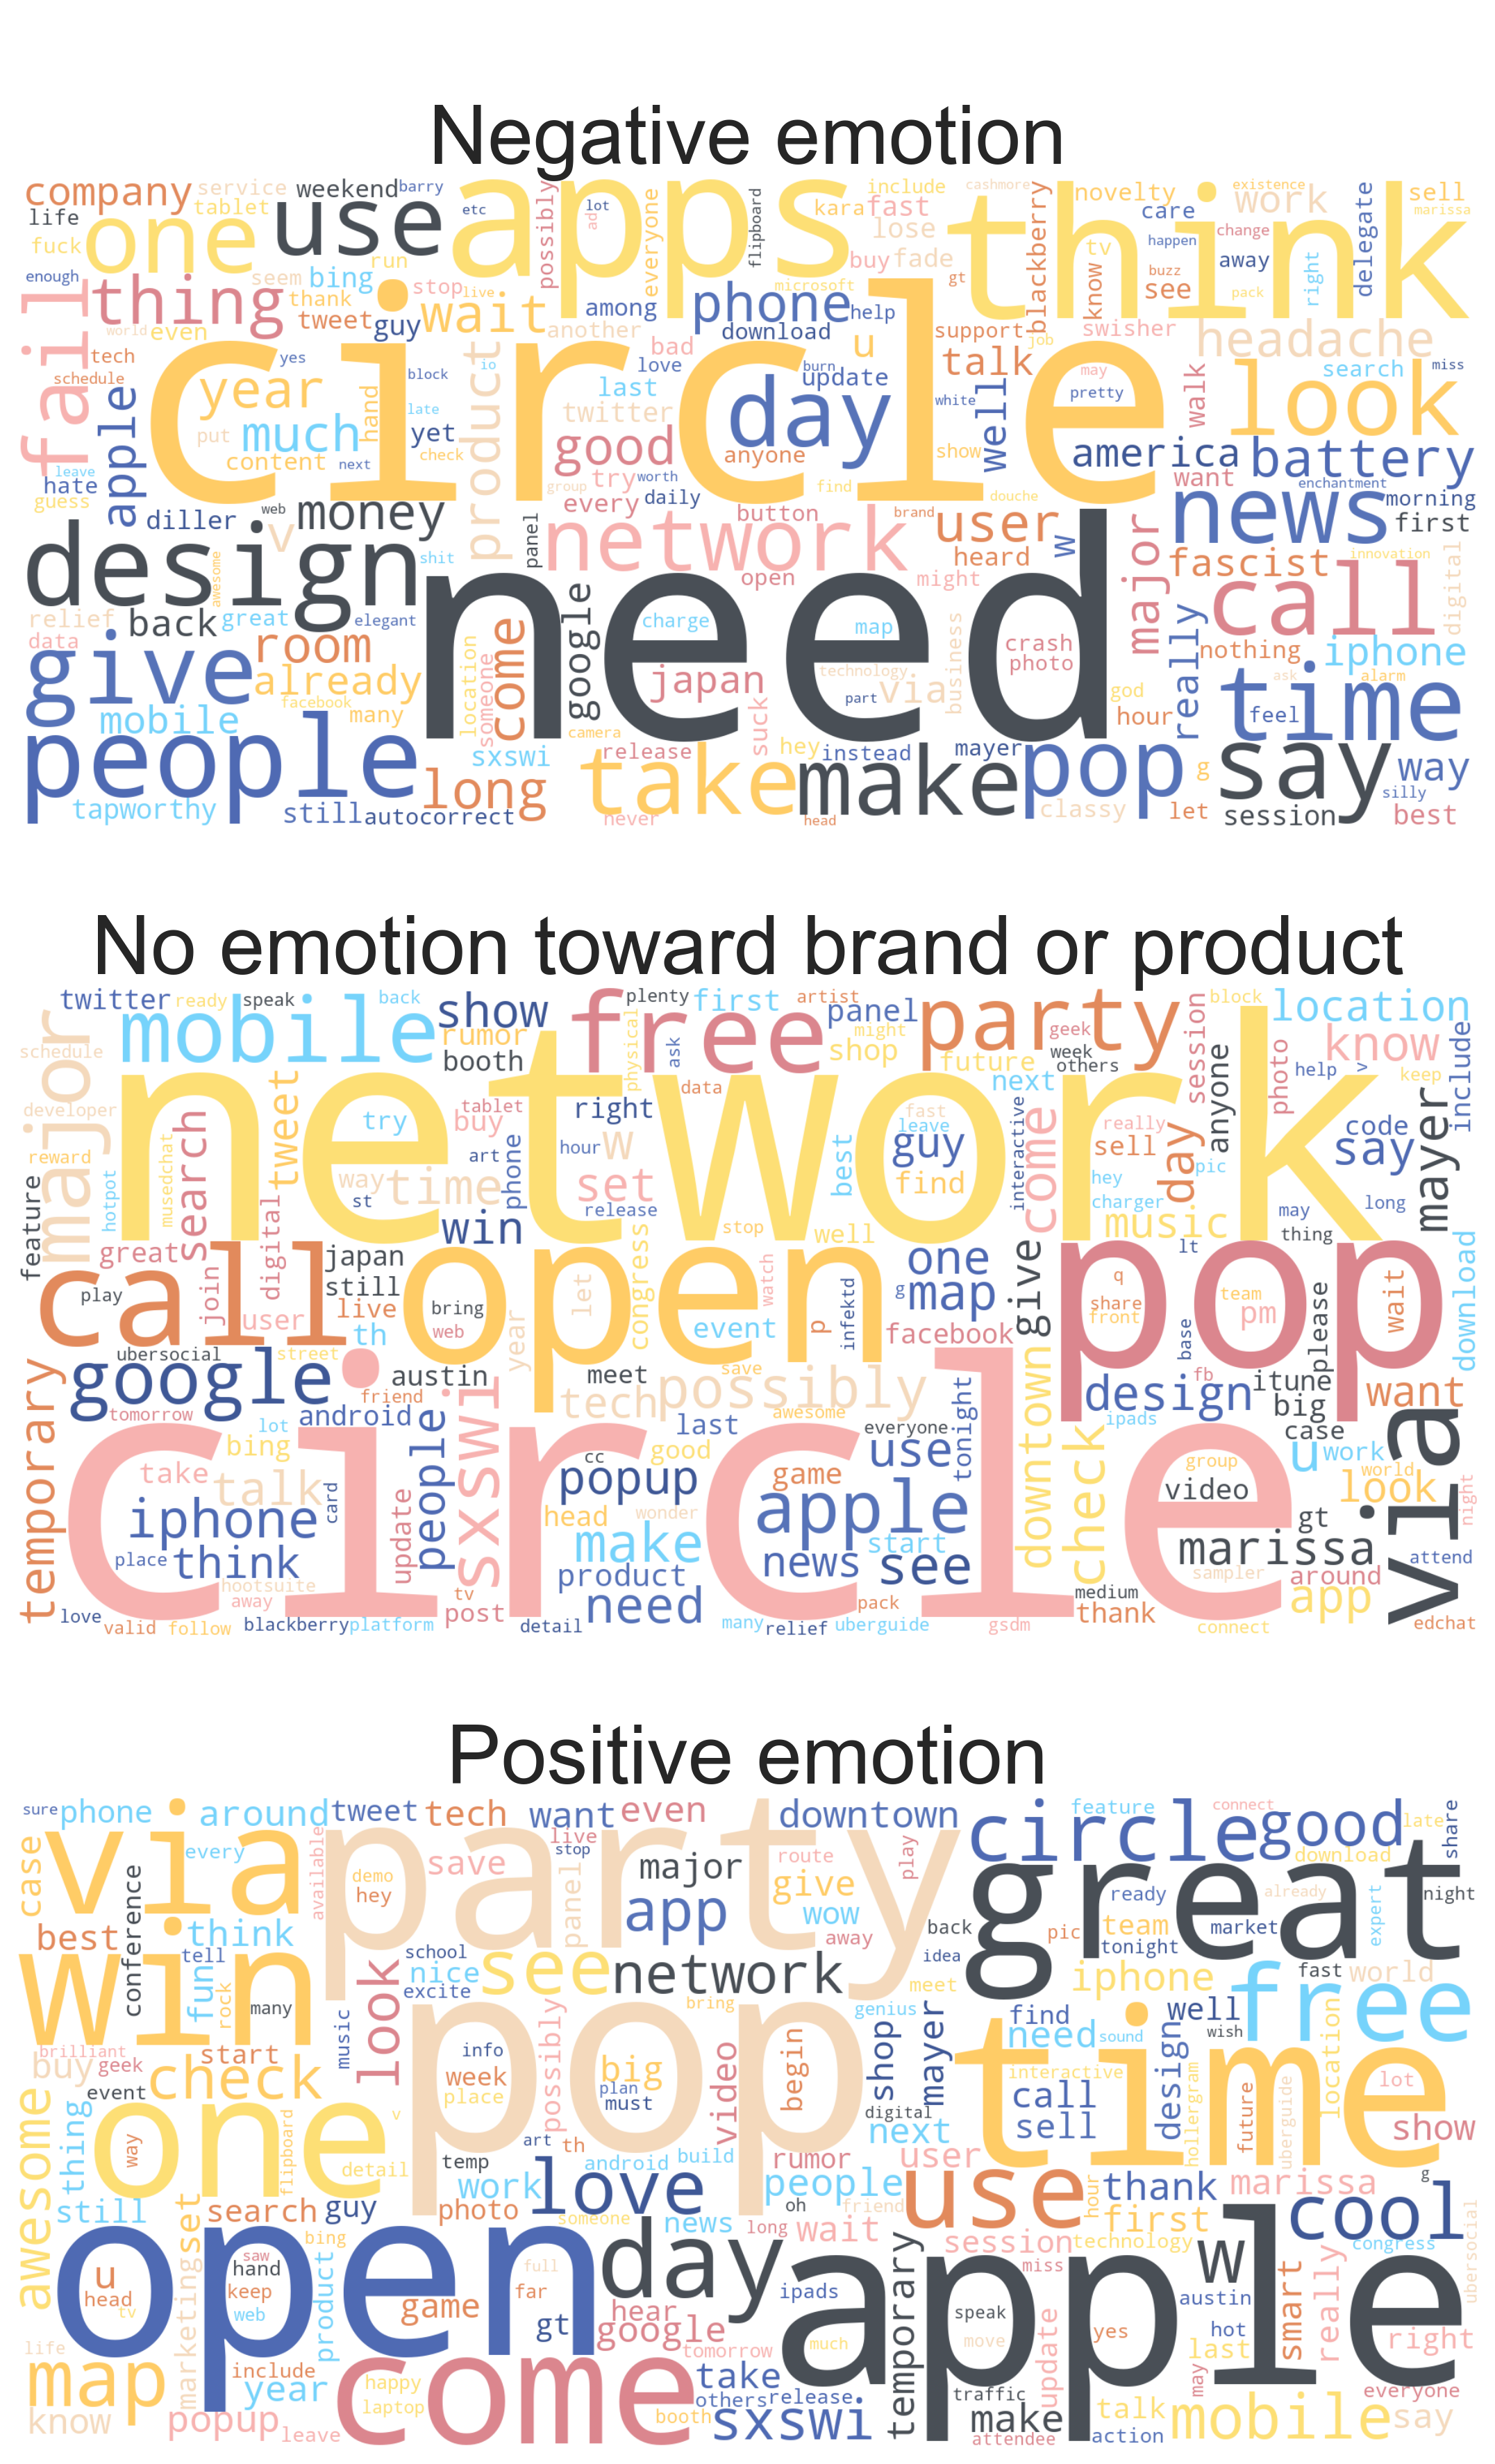

In [20]:
fig, ax = plt.subplots(3,1,figsize=(10,14),dpi=250)
for i, emo in enumerate(train['sentiment'].unique()):
    tmp_ = train[train['sentiment'] == emo]
    ax_ = ax[i]
    wordcloud = WordCloud(
        collocations=False, width=1800,height=800,
        background_color="#ffffff00",
        colormap=canvamap
        ).generate(' '.join(tmp_['tokenized']))
    ax_.set_title(f"\n{emo}",fontsize=34)
    ax_.imshow(wordcloud, interpolation='bilinear')
    ax_.axis('off')
plt.tight_layout(pad=0)

(-0.5, 1799.5, 799.5, -0.5)

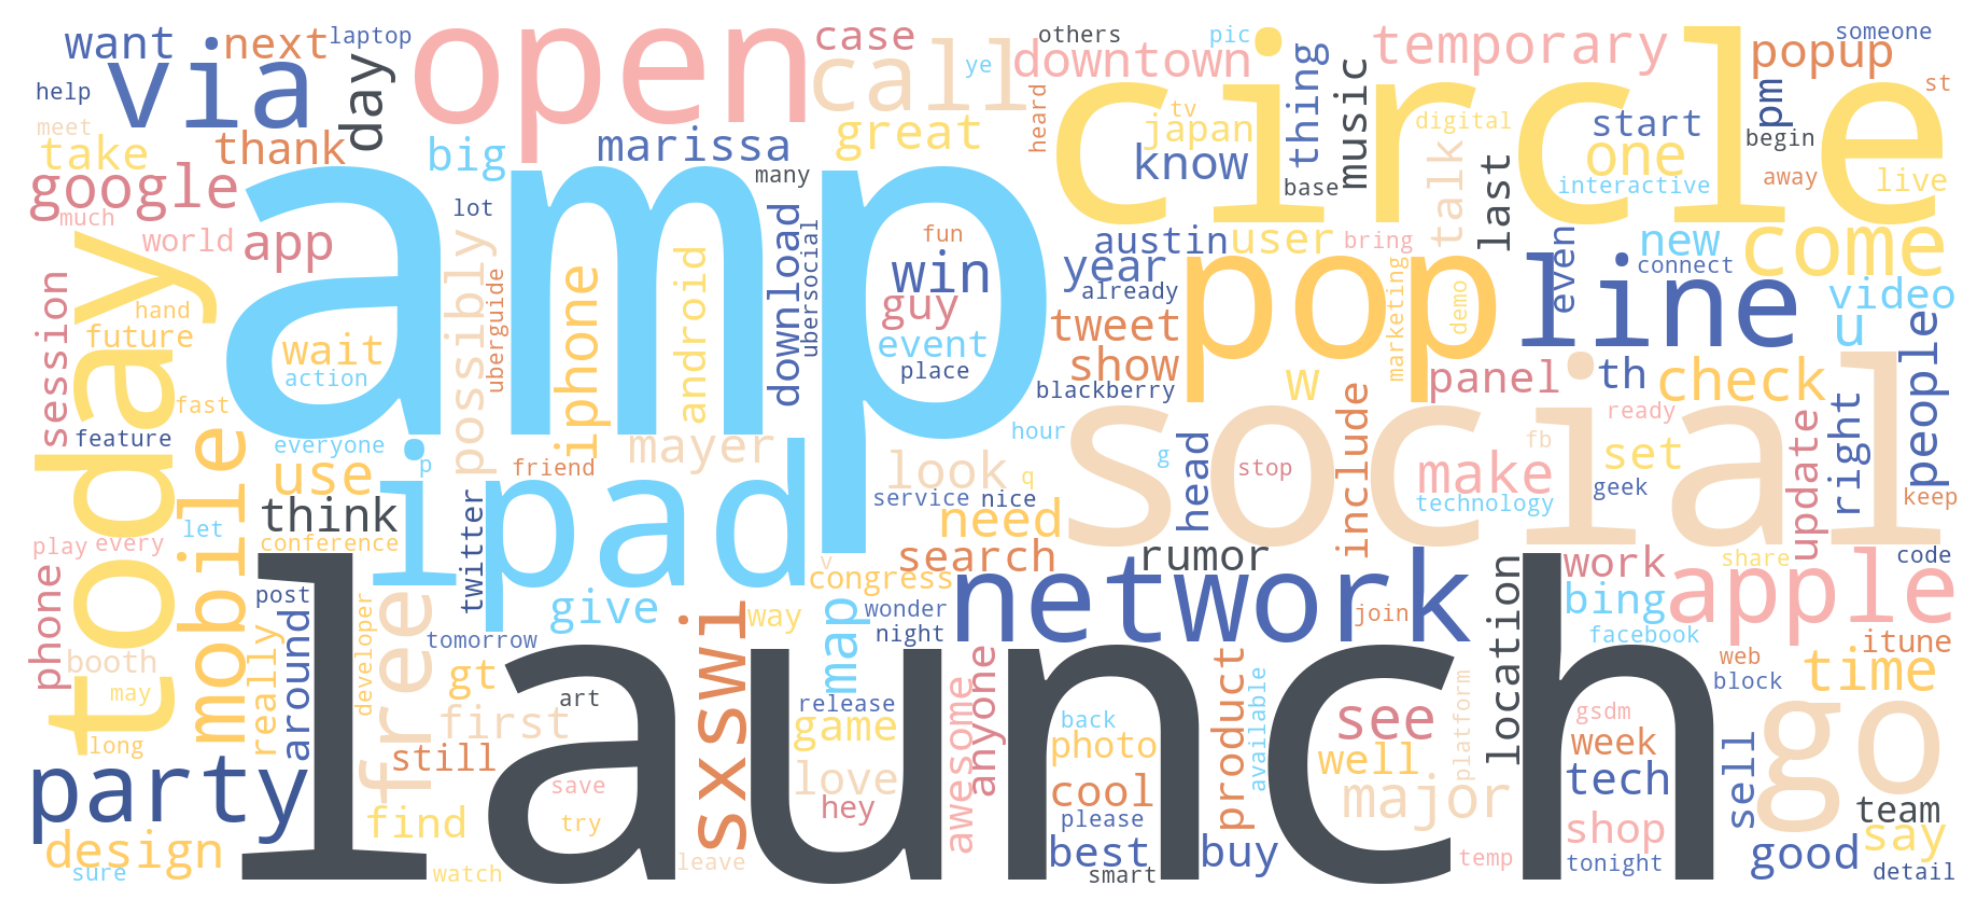

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,8),dpi=250)
wordcloud.generate(' '.join(sentiments['tokenized']))
ax.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

We can see that the word "Circle" appears at a high
volume in every category. Looking through the data,
this is because Google launched a social network called
"Circle" that was a large topic during the SXSW event
that was taking place during the time of our dataset's
collection.

In [18]:
sw.extend(['circle'])
train['tokenized'],train['tokens'] = \
    preprocess(train['tokenized'],sw,ret_tokens=True)

In [19]:
test['tokenized'], test['tokens'] = preprocess(test['tokenized'],sw,ret_tokens=True)
tfidf = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)

train_tfidf = tfidf.fit_transform(train['tokenized'])
test_tfidf = tfidf.transform(test['tokenized'])

train_vec = pd.DataFrame(train_tfidf.toarray(),columns=tfidf.get_feature_names())
test_vec = pd.DataFrame(test_tfidf.toarray(),columns=tfidf.get_feature_names())

In [20]:
test['tokenized'], test['tokens'] = preprocess(test['tokenized'],sw,ret_tokens=True)
test_tfidf = tfidf.transform(test['tokenized'])
test_vec = pd.DataFrame(test_tfidf.toarray(),columns=tfidf.get_feature_names())

In [23]:
# rfc = RandomForestClassifier(n_jobs=-2,random_state=13)
# knc = KNeighborsClassifier(n_jobs=-2)
# mnb = MultinomialNB()
# svc = SVC(random_state=13)

# scoring = make_scorer(custom_scorer)

# rfc_grid = {
#     'max_depth':[15,20,25,30],
#     'min_samples_split':[10,15,20]
# }
# knc_grid = {
#     'n_neighbors':[3,5,7,9]
# }
# mnb_grid = {
# }
# svc_grid = {
#     'kernel':['poly','rbf'],
#     'degree':[3,4]
# }

# rfc = GridSearchCV(
#     rfc,rfc_grid,
#     scoring=scoring
# )
# knc = GridSearchCV(
#     knc,knc_grid,
#     scoring=scoring
# )
# mnb = GridSearchCV(
#     mnb,mnb_grid,
#     scoring=scoring
# )
# svc = GridSearchCV(
#     svc,svc_grid,
#     scoring=scoring
# )

# classifiers = [rfc,knc,mnb,svc]

# majority_length = len(train[train['sentiment'] == 'No emotion toward brand or product'])
# sub_majority_length = len(train[train['sentiment'] == 'Positive emotion'])

# if sub_majority_length*2 > majority_length:
#     scale_size = sub_majority_length*2
# else:
#     scale_size = majority_length

# sm_dict = {
#     "No emotion toward brand or product"    : int(scale_size),
#     "Positive emotion"                      : int(scale_size*0.5),
#     "Negative emotion"                      : int(scale_size*0.5)
# }

# o = SMOTE(random_state=13)
# # o_grid = {
# #     'sampling_strategy':['minority','auto',sm_dict]
# # }
# o_grid = ['minority','auto',sm_dict]

# # o = GridSearchCV(
# #     o,o_grid,
# #     scoring=scoring
# # )
# pipe = imbPipeline(
#     steps=[
#         ('o',o),
#         ('search',DummyClassifier())
#     ]
# )

# grid = [
#     {'o':['passthrough'],
#      'search':[*classifiers]},
#     {'o':[o],
#     'o__sampling_strategy':o_grid,
#     'search':[*classifiers]}
# ]

In [24]:
# gs = GridSearchCV(
#     pipe,grid,scoring=scoring,
#     verbose=3
# )

In [25]:
# # even with parallel backend, this process takes ~45
# # minutes to run on 23 cores. 
# with parallel_backend('threading',n_jobs=-2):
#     gs.fit(train_vec,train['sentiment'])
# 
# # dump() is used to output the estimator as a file so
# # that it can be loaded later. 
# dump(gs.best_estimator_,'./data/best_estimator.pkl')

In [26]:
# dump(gs.best_estimator_,'./data/best_estimator.pkl')

In [27]:
# gs.best_estimator_, \
# gs.best_estimator_['search'], \
# gs.best_estimator_['search'].best_params_, \
# gs.best_score_

The best estimator determined by this process was a
pipeline with default values for SMOTE and for SVC.

In [25]:
# best_top   = gs.best_estimator_.steps[0][1]
# best_inner = gs.best_estimator_['search'].best_estimator_
# best_model = imbPipeline(
#     steps=[
#         ('scaler',best_top),
#         ('model',best_inner)
#     ]
# )
# # this will load our preserved model from earier 
best_model = load('./data/best_estimator.pkl')

In [ ]:
with parallel_backend('threading',n_jobs=-2):
    best_model.fit(train_vec,train['sentiment'])

In [ ]:
best_model

In [35]:
y_pred = best_model.predict(train_vec)
train['sentiment'].value_counts(), \
(fs_arr := f1_score(y_pred,train['sentiment'],average=None)), \
fs_arr[1:].mean()

(No emotion toward brand or product    4310
 Positive emotion                      2382
 Negative emotion                       456
 Name: sentiment, dtype: int64,
 array([0.79890311, 0.90939044, 0.8579932 ]),
 0.8836918210447277)

Our predictions on our training data look pretty decent
with our model picking up on around 88% of our positive
and negative values.

In [36]:
test_pred = best_model.predict(test_vec)
test['sentiment'].value_counts(), \
(fs_arr := f1_score(test_pred,test['sentiment'],average=None)), \
fs_arr[1:].mean()

(No emotion toward brand or product    1078
 Positive emotion                       596
 Negative emotion                       114
 Name: sentiment, dtype: int64,
 array([0.36866359, 0.74495742, 0.57624113]),
 0.6605992764749453)

Our model looks pretty over-fit at this point. We're
getting about a 66% f1 score on our testing data, which
is pretty close to what our CV scores were earlier on
in the process. This may not be perfect, but it can
still give us some pretty reasonable insights into our
data and may make the process of hunting down problems
that the public is concerned about.

Let's take a look at something we found earlier -
entries that were marked as "I can't tell."

This isn't really something we can automatically verify
and score against without some extra data entry, but we
can subjectively gauge our model's effectiveness at a
cursory level.

In [38]:
rc_est = preprocess(reclassify['tweet_text'],sw)
rc_tfidf = tfidf.transform(rc_est)
rc_vec = pd.DataFrame(rc_tfidf.toarray(),columns=tfidf.get_feature_names())
reclassify['predicted_sentiment'] = best_model.predict(rc_vec)


In [39]:
rc_neu = reclassify[
    reclassify['predicted_sentiment']=='No emotion toward brand or product'
    ].sample(5)['tweet_text'].values
rc_neg = reclassify[
    reclassify['predicted_sentiment']=='Negative emotion'
    ].sample(5)['tweet_text'].values
rc_pos = reclassify[
    reclassify['predicted_sentiment']=='Positive emotion'
    ].sample(5)['tweet_text'].values

tweet_types = [
    ('Neutral tweets',rc_neu),
    ('Positive tweets',rc_pos),
    ('Negative tweets',rc_neg)]
md = []
nlc = '\n'
for type_ in tweet_types:
    header = f"\n\n<br/>\n<br/>\n\n | {type_[0]} |\n|---|"
    body = []
    for item_ in type_[1]:
        body.append(f"| {item_} |")
    md.append(f"{header}\n{nlc.join(body)}")

Markdown('\n'.join(md))



<br/>
<br/>

 | Neutral tweets |
|---|
| @mention yeah, we have @mention , Google has nothing on us :) #SXSW |
| I wish the apple store employees cheering for all the people in line at the pop up apple store would cheer me on while I do timesheets #SXSW |
| I won't be at #sxsw and I won't be in line to buy iPad 2.0 tomorrow. #notwinning. |
| From #SXSW: @mention says @mention playing with NFC for next gen devices. Nexus S now, iPhone 5 next? |
| Why Barry Diller thinks iPad only content is nuts @mention #SXSW {link} |


<br/>
<br/>

 | Positive tweets |
|---|
| Google should put those engineers formerly behind real estate listings into renewing the Google Checkout project. #SXSW |
| This @mention article about #SXSW is so good I'm linking to it on an iPhone on a train, which is the opposite of easy: {link} |
| Nuts.  ÛÏ@mention @mention (via @mention #sxsw ipad store sold out of everything except 64gig wifi only whiteÛ |
| I'll bet there's a lot of nerds at #SXSW using the #iPhone Light Saber app in barroom brawls instead of their fists. |
| Catch 22Û_ I mean iPad 2 at #SXSW : {link} |


<br/>
<br/>

 | Negative tweets |
|---|
| @mention RWW: Google Circles will be ______    #sxsw {link} |
| The iPad 2 is the also a cartoonishly large digital camera. #SXSW #CStejas {link} |
| I really think that most of the iPad 2 stock went down to #SXSW. |
| Entrapment. Layer upon layer RT: @mention Google Circles will be ______ #sxsw&quot; |
| Anyone who was going to buy a new iPad should donate to #Japan #tsunami victims instead. #sxsw |